# Imports

In [2]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np

# Test of functions

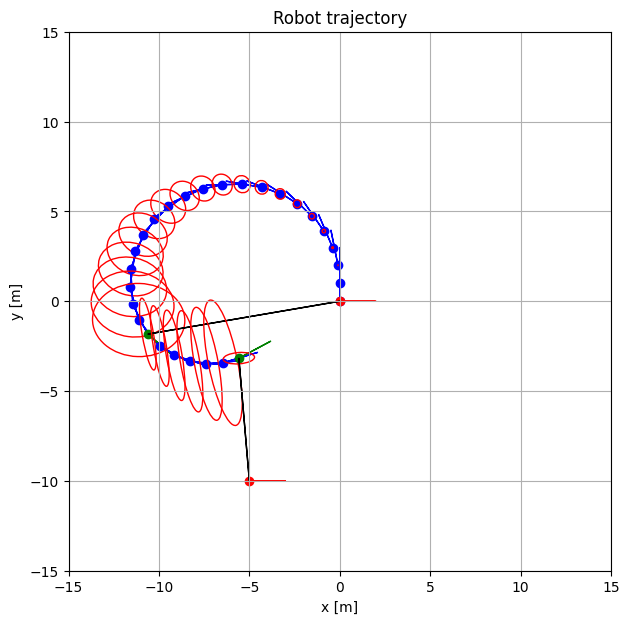

In [3]:
fig, ax = rp.setup_plot()

mmi = mf.MotionModel(x0=np.array([[3.14/2],[0],[0],[0],[0],[1],[0],[0],[0],[0],[0]]), Q=np.diag([0.1, 0.1, 0.1, 0.00001, 0.00001, 0.00001]))
mmj = mf.MotionModel()
mmk = mf.MotionModel(x0=np.array([[0],[0],[-5],[-10],[0],[0],[0],[0],[0],[0],[0]]))
measi = mf.MeasModel(R=np.diag([0.1, 0.1, 0.001, 0.001, 0.001]))
measj = mf.MeasModel()
meask = mf.MeasModel()

rp.plot_position2(ax, mmi.x, mmi.P)
y = np.array([[0.2], [0], [0.2]])
for i in range(20):
    mmi.predict()
    mmi.propagate()
    mf.KF_IMU(mmi, measi, y)
    rp.plot_position2(ax, mmi.x, mmi.P)

rp.plot_position(ax, mmj.x, color='r')
rp.plot_position(ax, mmk.x, color='r')

# Perform correction using anchor
mmi.predict()
mmi.propagate()

yfull = measi.h_full(mmi.x, mmj.x, measj.t)
yfull[mf.Z_W:] = y

mf.KF_full(mmi, mmj, measi, measj, yfull)
rp.plot_position2(ax, mmi.x, mmi.P, color='g')
rp.plot_measurement(ax, mmi.x, mmj.x)

for i in range(5):
    mmi.predict()
    mmi.propagate()
    mf.KF_IMU(mmi, measi, y)
    rp.plot_position2(ax, mmi.x, mmi.P)

# Perform second correction
mmi.predict()
mmi.propagate()

yfull = measi.h_full(mmi.x, mmk.x, meask.t)
yfull[mf.Z_W:] = y

mf.KF_full(mmi, mmk, measi, meask, yfull)
rp.plot_position2(ax, mmi.x, mmi.P, color='g')
rp.plot_measurement(ax, mmi.x, mmk.x)



# Test of IMU generate

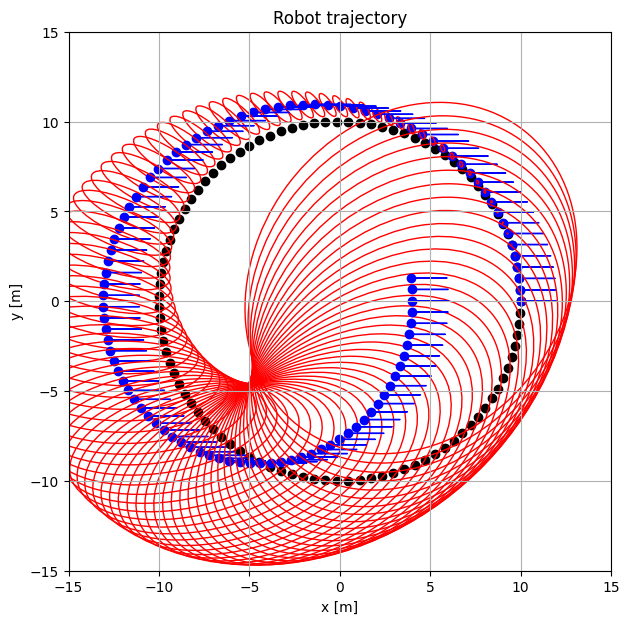

In [ ]:
# IMU measurements:
dt = 0.1
pos, y_IMU, x0 = traj.gen_circ_traj_norot(10, 100, dt=dt)

mmi = mf.MotionModel(x0=x0, dt=dt, Q=np.diag([1e6, 1e6, 1e6, 0.00001, 0.00001, 0.00001]))
measi = mf.MeasModel(R=np.diag([0.0001, 0.0001, 0.1, 0.1, 0.1]))
mmj = mf.MotionModel(dt=dt)
measj = mf.MeasModel()

fig, ax = rp.setup_plot()

ax.scatter(pos[1,:], pos[2,:], c='black')

rp.plot_position2(ax, mmi.x, mmi.P)
meas_num = y_IMU.shape[1]
for i in range(meas_num):
    mmi.predict()
    mmi.propagate()
    if (i == meas_num/4) or (i == meas_num/2) or (i==3*meas_num/4) or (i==meas_num-1):
        y_rb = traj.gen_rb(pos[0,i], 
                           mmj.x[mf.X_THETA, 0], 
                           pos[1:3, i:i+1], 
                           mmj.x[mf.X_P],
                           measi.t,
                           measj.t)
        # Concatanate the two measurement vectors
        y_full = np.concatenate((y_rb, y_IMU[:, i:i+1]), axis=0)
        mf.KF_full(mmi, mmj, measi, measj, y_full)
        rp.plot_measurement(ax, mmi.x, mmj.x)
    else:
        mf.KF_IMU(mmi, measi, y_IMU[:,i:i+1])
    rp.plot_position2(ax, mmi.x, mmi.P)
mmi.predict()
mmi.propagate()
rp.plot_position2(ax, mmi.x, mmi.P)
